<center><img src="images/clothing.jpg"></center>

Welcome to the world of e-commerce, where customer feedback is a goldmine of insights! In this project, you'll dive into the Women's Clothing E-Commerce Reviews dataset, focusing on the 'Review Text' column filled with direct customer opinions.

Your mission is to use text embeddings and Python to analyze these reviews, uncover underlying themes, and understand customer sentiments. This analysis will help improve customer service and product offerings.

## The Data

You will be working with a dataset specifically focusing on customer reviews. Below is the data dictionary for the relevant field:

## womens_clothing_e-commerce_reviews.csv

| Column        | Description                           |
|---------------|---------------------------------------|
| `'Review Text'` | Textual feedback provided by customers about their shopping experience and product quality. |

Armed with access to powerful embedding API services, you will process the reviews, extract meaningful insights, and present your findings.

Let's get started!

## Install useful libraries

In [138]:
# Run this cell to install ChromaDB if desired
try:
    assert version('chromadb') == '0.4.17'
except:
    !pip install chromadb==0.4.17
try:
    assert version('pysqlite3') == '0.5.2'
except:
    !pip install pysqlite3-binary==0.5.2
__import__('pysqlite3')
import sys
sys.modules['sqlite3'] = sys.modules.pop('pysqlite3')
import chromadb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


## Load the dataset
Load data and perform basic data checks to ensure you are using relevant data for the analysis

In [139]:
# Load the dataset
import pandas as pd
reviews = pd.read_csv("womens_clothing_e-commerce_reviews.csv")

# Display the first few entries
reviews.head()

,Review ID,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [140]:
# Call OpenAI Client

from openai import OpenAI
client = OpenAI()

In [141]:
# Clean data and create embeddings

def get_reviews(df):
    # get reviews from pd.df
    df_reviews = df["Review Text"].dropna()
    reviews_dict = []
    for row in df_reviews:
        reviews_dict.append({'review': row, 'embedding': None})
    return reviews_dict

def create_embeddings(input):
    # create embeddings
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=input
    )
    return response.model_dump()

def store_embeddings_list(response_dict):
    embeddings = []
    
    for entry in response_dict["data"]:
        embeddings.append(entry["embedding"])

    return embeddings

In [142]:
# Create 'Review Text' embeddings

reviews_dict = get_reviews(reviews)
reviews_list = [review["review"] for review in reviews_dict]

response_dict = create_embeddings(reviews_list)
embeddings = store_embeddings_list(response_dict)

for idx, review in enumerate(reviews_dict):
    review["embedding"] = embeddings[idx]

In [143]:
# Reduce embeddings and visualize database

from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def reduce_embeddings(embeddings, perplexity):
    # reduce into 2 dimensions
    tsne = TSNE(n_components=2, perplexity=perplexity)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))

    return embeddings_2d

def visualize_embeddings(embeddings_2d):
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
    plt.show()

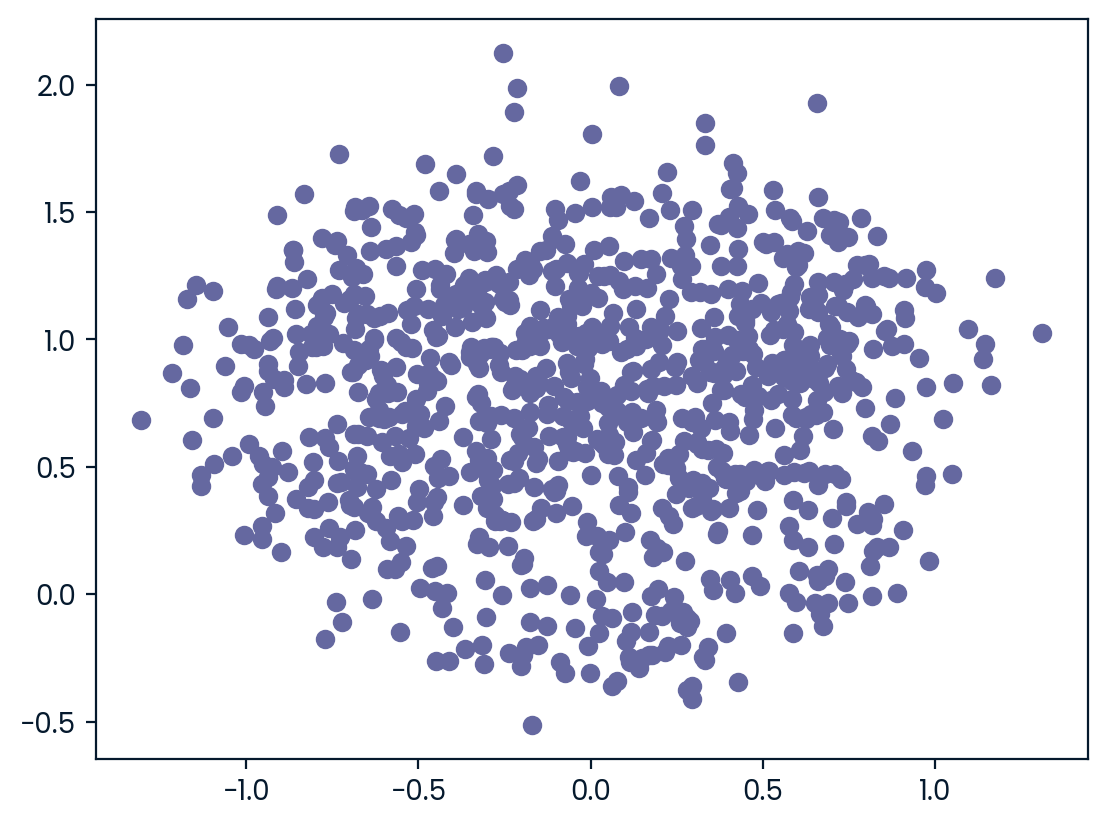

In [144]:
# Reduce embeddings to chosen perplexity and visualize

# perplexity=800: least value that has divergence < 0.1
embeddings_2d = reduce_embeddings(embeddings, 800)
visualize_embeddings(embeddings_2d)

In [145]:
# Categorize feedback

from scipy.spatial import distance

def categorize_feedback(topics_list, list_of_reviews, review_embeddings):
    reviews = []
    for topic in topics_list:
        distances = []
        for review in review_embeddings:
            dist = distance.cosine(topic["embedding"], review)
            distances.append(dist)
        min_dist_ind = np.argmin(distances)
        reviews.append(list_of_reviews[min_dist_ind])
        
    return reviews

In [146]:
# Create list of topics with embedding

topics_list = [
          {'label': 'Quality', 'embedding': None}, 
          {'label': 'Fit', 'embedding': None}, 
          {'label': 'Style', 'embedding': None}, 
          {'label': 'Comfort', 'embedding': None}, 
          {'label': 'Price', 'embedding': None}, 
        ]

topics = [topic["label"] for topic in topics_list]
topic_embedding_dict = create_embeddings(topics)
topic_embeddings = store_embeddings_list(topic_embedding_dict)

for idx, embedding in enumerate(topic_embeddings):
    topics_list[idx]["embedding"] = embedding

In [147]:
# Search for reviews related to each topic

filtered_reviews = categorize_feedback(topics_list, list_of_reviews, embeddings)
for idx, topic in enumerate(topics_list):
    topic["review"] = filtered_reviews[idx]
    print(f'{topic["label"]}:\n{topic["review"]}\n')

Quality:
This top is soo pretty with a cool edge.
it looks and feels like really good quality.

Fit:
Adorable sweater with a loose knit that helps slim down my man-back appearance. cut is tapered to the body but with a soft flare at the bottom hem. not clingy, very soft fabric doesn't accentuate bulges so i am happy about it's forgiving silhouette.

Style:
Great style!

Comfort:
Absolutely wonderful - silky and sexy and comfortable

Price:
Unusual color. expensive even on sale.



In [148]:
# Similarity search
def search_similar_reviews(input_review, embeddings, reviews_list, n=3):
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=input_review
    )
    input_vector = response.model_dump()["data"][0]["embedding"]

    distances = []
    for index, embedding in enumerate(embeddings):
        dist = distance.cosine(input_vector, embedding)
        distances.append({"distance": dist, "index": index})
    distances_sorted = sorted(distances, key=lambda x: x["distance"])

    similar_reviews = []
    for review in distances_sorted[0:n]:
        similar_reviews.append(reviews_list[review["index"]])

    return similar_reviews

In [149]:
input_review = "Absolutely wonderful - silky and sexy and comfortable"

most_similar_reviews = search_similar_reviews(input_review, embeddings, reviews_list)

print(f"Selected Review: '{input_review}'\n\nMost Similar Reviews to Selected Review:")
for idx, review in enumerate(most_similar_reviews):
    print(f"{idx+1}. '{review}'")

Selected Review: 'Absolutely wonderful - silky and sexy and comfortable'

Most Similar Reviews to Selected Review:
1. 'Absolutely wonderful - silky and sexy and comfortable'
2. 'Very comfortable and versatile. got lots of compliments.'
3. 'This is a very comfortable and sexy sleep dress, the way it drapes. i can see that the type of fabric is not suitable for out and about activities and can catch on snags, etc. very easily. once i relegated it to the nightgown category it became my favorite item to wear and lounge in.'
